In [1]:
import atlite
import xarray as xr
import pandas as pd
import scipy.sparse as sp
import numpy as np

from collections import OrderedDict

In [2]:
# Two FIAS internal modules that provide some geohelper functions.
# The vresutils package is not on github, yet, but preliminarily available at
#
#   http://fias.uni-frankfurt.de/~hoersch/vresutils.git

from vresutils import shapes as vshapes, transfer as vtransfer

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('ticks')
#sns.set_context('talk')

# Download and Extract Data-Files

In [4]:
import requests
import os
import zipfile

# variant of http://stackoverflow.com/a/16696317
def download_file(url, local_filename):
    if not os.path.exists(local_filename):
        r = requests.get(url, stream=True)
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk:
                    f.write(chunk)
    return local_filename

opsd_fn = download_file('http://data.open-power-system-data.org/index.php?package=time_series&version=2017-03-06&action=customDownload&resource=1&filter%5B_contentfilter_utc_timestamp%5D%5Bfrom%5D=2012-01-01&filter%5B_contentfilter_utc_timestamp%5D%5Bto%5D=2013-01-01&filter%5BRegion%5D%5B%5D=DE&filter%5BVariable%5D%5B%5D=solar&filter%5BVariable%5D%5B%5D=wind&filter%5BAttribute%5D%5B%5D=generation&downloadCSV=Download+CSV',
                        'data/time_series_60min_singleindex_filtered.csv')

eeg_fn = download_file('http://www.energymap.info/download/eeg_anlagenregister_2015.08.utf8.csv.zip',
                        'data/eeg_anlagenregister_2015.08.utf8.csv.zip')

with zipfile.ZipFile(eeg_fn, "r") as zip_ref:
    zip_ref.extractall("data")

cutout_fn = download_file('http://fias.uni-frankfurt.de/~hoersch/data/germany-2012.zip',
                          'data/germany-2012.zip')
with zipfile.ZipFile(cutout_fn, "r") as zip_ref:
    zip_ref.extractall("cutouts")

In [5]:
opsd = pd.read_csv(opsd_fn, parse_dates=True, index_col=0)

# Create cutout

Needs the monthly files for the CFSv2 datasets available at the directory `atlite.config.ncep_dir` in a specific undocumented directory structure. For now this section is just here as an illustration.

```python
de = vshapes.germany()
x1, y1, x2, y2 = de.bounds
```

```python
cutout = atlite.Cutout('germany-2012',
                       module='ncep', cutout_dir='cutouts',
                       xs=slice(x1 - 0.2, x2 + 0.2), ys=slice(y2 + 0.2, y1 - 0.2),
                       years=slice(2012, 2012))
```

```python
%%time
cutout.prepare()
```
(The runtime is about 15min)

# Creating time-series


In [6]:
cutout = atlite.Cutout('germany-2012', cutout_dir='cutouts')

In [7]:
def postcodes2gridcells(cutout):
    postcodes = pd.Series(vshapes.postcodeareas()).dropna()
    grid_cells = cutout.grid_cells()
    return postcodes.index, vtransfer.Shapes2Shapes(np.asarray(postcodes), grid_cells)

In [8]:
%%time
postcodes, posttransfer = postcodes2gridcells(cutout)

Serving call to postcodeareas from file vresutils.shapes.postcodeareas_ver2__.pickle of cache: 190.3 msec
CPU times: user 2min 6s, sys: 124 ms, total: 2min 7s
Wall time: 2min 7s


In [9]:
def capacity_layout(cutout, typ, bins=None, until=None,
                    eeg_fn='data/eeg_anlagenregister_2015.08.utf8.csv'):
    cols = OrderedDict((('installation_date', 0),
                        ('plz', 2), ('city', 3),
                        ('type', 6),
                        ('capacity', 8), ('level', 9),
                        ('lat', 19), ('lon', 20),
                        ('validation', 22)))
    data = pd.read_csv(eeg_fn,
                       sep=';', decimal=',', thousands='.',
                       comment='#', header=None,
                       usecols=list(cols.values()),
                       names=list(cols.keys()),
                       dtype={'installation_date': str},
                       na_values=('O04WF', 'keine'))

    # Only those installations of the correct type which passed validation and specify a plz
    data = data[(data.type == typ) & (data.validation == 'OK') &
                (~ data.plz.isnull())]
    
    if until is not None:
        data = data[pd.to_datetime(data.installation_date, format='%d.%m.%Y') <= str(until)]

    if bins is not None:
        aggregated_capacity = data.capacity.groupby([data.plz, pd.cut(data.capacity, bins, labels=False)]).sum().unstack()
        shape = (-1,) + cutout.shape
    else:
        aggregated_capacity = data.capacity.groupby(data.plz).sum()
        shape = cutout.shape

    capacity_layout = posttransfer.dot(aggregated_capacity.reindex(postcodes).fillna(0.)).T.reshape(shape)

    return capacity_layout / 1e3 # capacity in MW

## Solar

In [10]:
layout = capacity_layout(cutout, 'Solarstrom', until=2012)

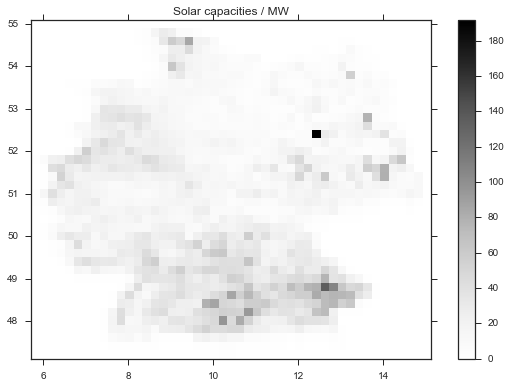

In [11]:
plt.imshow(layout.T, extent=cutout.extent, interpolation='None')
plt.colorbar()
plt.title('Solar capacities / MW')
plt.tight_layout()

In [12]:
capacity_per_unit = atlite.resource.solarpanel_rated_capacity_per_unit("Sunpower")

In [13]:
%%time
pv = cutout.pv(panel="Sunpower", orientation={'slope': 30., 'azimuth': 0.},
               layout=layout / capacity_per_unit)

CPU times: user 13.9 s, sys: 492 ms, total: 14.4 s
Wall time: 14.4 s


In [15]:
pv_df = pd.DataFrame(dict(atlite=pv.sel(dim_0=0).to_pandas(),
                          opsd=opsd['DE_solar_generation'])) / 1e3

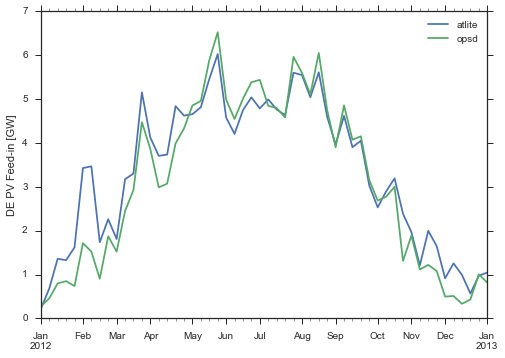

In [16]:
pv_df.resample('1W').mean().plot.line()
plt.ylabel('DE PV Feed-in [GW]')

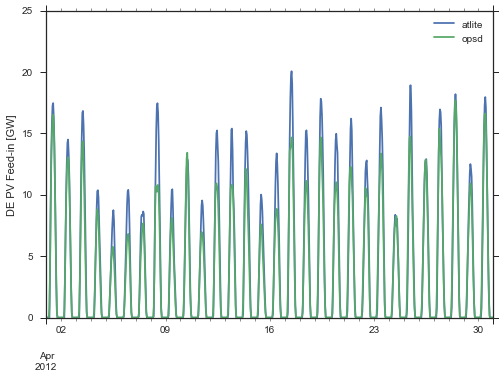

In [17]:
pv_df.loc["2012-04"].plot()
plt.ylabel('DE PV Feed-in [GW]')

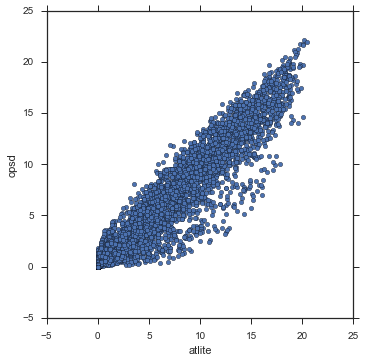

In [18]:
pv_df.plot(x='atlite', y='opsd', kind='scatter').set_aspect('equal')

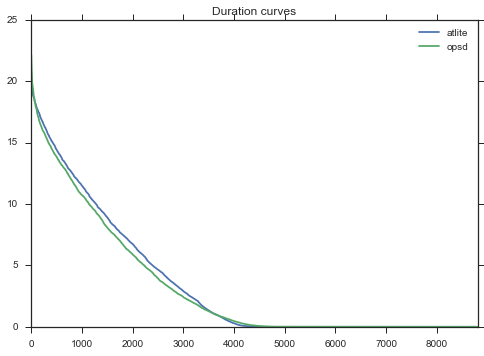

In [19]:
pv_df['atlite'].sort_values(ascending=False).reset_index(drop=True).plot()
pv_df['opsd'].sort_values(ascending=False).reset_index(drop=True).plot()
plt.legend()
plt.title('Duration curves')

## Wind

In [20]:
turbines = pd.DataFrame([
        dict(name='Vestas_V25_200kW', bin=400.),
        dict(name='Vestas_V47_660kW', bin=700.),
        dict(name='Bonus_B1000_1000kW', bin=1100.),
        dict(name='Suzlon_S82_1.5_MW', bin=1600.),
        dict(name='Vestas_V66_1750kW', bin=1900.),
        dict(name='Vestas_V80_2MW_gridstreamer', bin=2200.),
        dict(name='Siemens_SWT_2300kW', bin=2500.),
        dict(name='Vestas_V90_3MW', bin=50000.)
    ]
)

In [21]:
layouts = capacity_layout(cutout, 'Windkraft',
                          bins=np.r_[0, turbines["bin"]],
                          until=2012)

In [22]:
%%time
wind = sum(
    cutout.wind(turbine=t.name,
                layout=l / atlite.resource.windturbine_rated_capacity_per_unit(t.name))
    for t, l in zip(turbines.itertuples(), layouts)
)

CPU times: user 8.51 s, sys: 356 ms, total: 8.86 s
Wall time: 8.91 s


In [32]:
wind_df = pd.DataFrame(dict(atlite=wind.sel(dim_0=0).to_pandas(),
                            opsd=opsd['DE_wind_generation'])) / 1e3

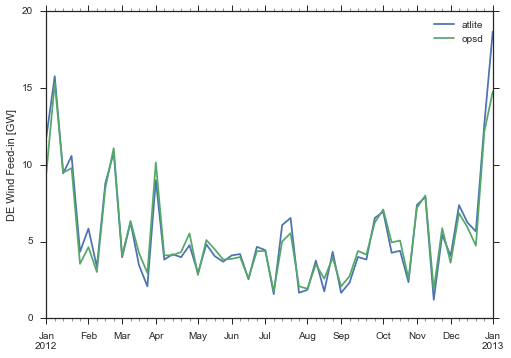

In [33]:
wind_df.resample('1W').mean().plot.line()
plt.ylabel('DE Wind Feed-in [GW]')

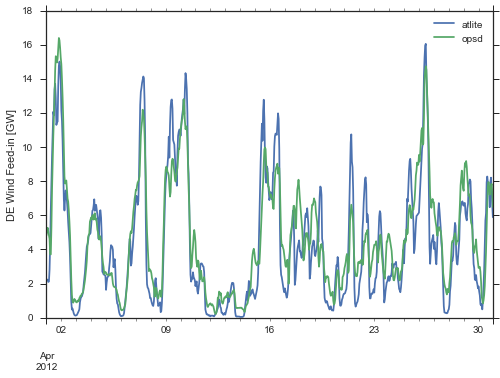

In [34]:
wind_df.loc["2012-04"].plot()
plt.ylabel('DE Wind Feed-in [GW]')

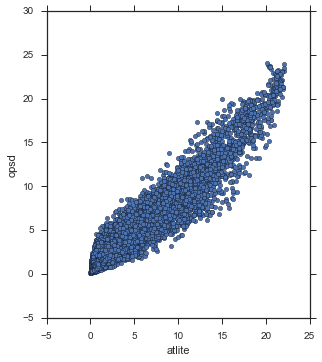

In [35]:
wind_df.plot(x='atlite', y='opsd', kind='scatter').set_aspect('equal')

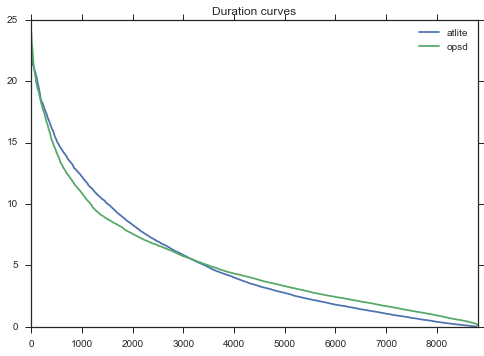

In [36]:
wind_df['atlite'].sort_values(ascending=False).reset_index(drop=True).plot()
wind_df['opsd'].sort_values(ascending=False).reset_index(drop=True).plot()
plt.legend()
plt.title('Duration curves')

## Splitting time-series into shapes

In [37]:
laender = pd.Series(vshapes.laender())
laender.index = laender.index.rename('land')

Serving call to laender from file vresutils.shapes.laender_ver2__.pickle of cache: 2.3 msec


<class 'shapely.geometry.polygon.Polygon'>


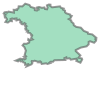

In [38]:
print(type(laender['BY']))
laender['BY']

In [30]:
%%time
pv = cutout.pv(panel="Sunpower", orientation={'slope': 30., 'azimuth': 0.},
               shapes=laender,
               layout=layout / capacity_per_unit)

CPU times: user 15.3 s, sys: 508 ms, total: 15.8 s
Wall time: 15.8 s


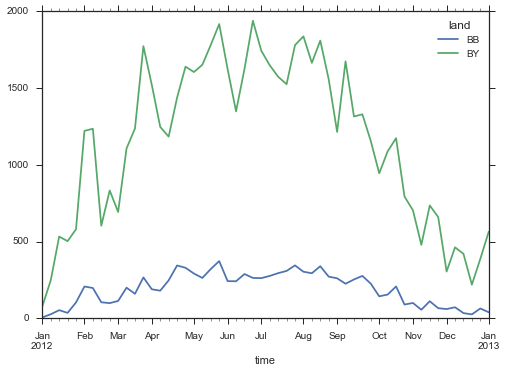

In [31]:
pv.sel(land=['BB', 'BY']).T.to_pandas().resample('1W').mean().plot()